# Importing packages 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import statsmodels.api as sm


import scipy.stats
import random
from fitter import Fitter
import attr

from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import defaultdict, OrderedDict
# Local package
import pylogit as pl

# Define the necessary functions

## Function for getting distributions for nodes with no parents

In [4]:
class FitDistribution(object):
    """Fit and simulate data to known distributions.

    Input:
    ------
    - data: array-like or dataframe.
    - dists: list.
        This parameter contains a list of distributions to be explored.
        When None, every available distribution on scipy is explored.
    - bins: int.
        Numbers of bins to be used for the cumulative histogram. This has
        an impact on the quality of the fit.
    - timeout: int.
        Maximum time for a given distribution. If timeout is reached,
        the distribution is skipped.
        """
    def __init__(self, data, dists=None, timeout=30, verbose=False, bins=100):
        self.data = data
        # self.var_types = var_types
        self.dists = dists
        self.timeout = timeout
        self.verbose = verbose
        self.bins = bins
        self.ArrayDistDict = defaultdict()
        self.params_dict = defaultdict(dict)

    def FindArrayDist(self, cat_var):
        """Function to extract the best distribution for a specified array.
        Uses the fit method from the Fitter module in the fitter library
        Inputs:
        -------
        - cat_var: boolean
            Boolean to signify whether the variable to be simulated
            is discrete/categorical or continuous.

        Outputs:
        -------
        By default, the function returns a dictionary with best distribution
        name and parameters associated with it. If a number of distributions
        was specified, the function returns a pandas DataFrame with
        the N best distributions, along with a plot showing all of them."""
        self.ArrayDistDict = dict()
        if cat_var is True:
            self.ArrayDistDict['distribution'] = 'categorical'
            np_array_range = np.arange(self.data.max()+1)
            array_bincount = np.bincount(self.data)
            probs = array_bincount / len(self.data)

            self.ArrayDistDict['parameters'] = [np_array_range,
                                                probs]
        else:
            fitter_object = Fitter(data=self.data,
                                   distributions=self.dists,
                                   timeout=self.timeout)
            fitter_object.fit()
            BestDict = fitter_object.get_best()
            self.ArrayDistDict['distribution'] = list(BestDict.items())[0][0]
            self.ArrayDistDict['parameters'] = list(BestDict.items())[0][1]
        return self.ArrayDistDict

    def SimArray(self, size=100):
        """Function to simulate data for an array based on the best fitted
        distribution.
        Input:
        -----
        - size : int
                size of the array to be simulated.
        Outputs:
        -------
        Simulated array based on the best fit distribution."""
        if self.ArrayDistDict['distribution'] == 'categorical':
            value = self.ArrayDistDict['parameters'][0]
            freq = self.ArrayDistDict['parameters'][1]
            Sim_Array = np.random.choice(a=value,
                                         p=freq,
                                         size=size)
        else:
            dist = getattr(scipy.stats, self.ArrayDistDict['distribution'])
            Sim_Array = dist.rvs(*self.ArrayDistDict['parameters'], size=size)
        return Sim_Array

    def FindDfDist(self, var_types):
        """Function to extract the best distribution from a specified
        dataframe. Uses the function find_dist, which in turn uses the
        fit method from the Fitter module in the fitter library
        Inputs:
        -------
        - var_types: dictionary
            Dictionary with keys as column names for dataset variables,
            the value of each key is a string showing whether the
            variable is discrete/cat or continuous.

        Outputs:
        -------
        *FOR NOW*, the function returns a dictionary showing the best
        distribution name for each array in the dataframe and parameters
        associated with it.
        """

        for column in list(self.data.columns):

            if var_types[column] == 'categorical':
                if len(self.data[column].unique()) == 1:
                    self.params_dict[column]['distribution'] = 'constant'
                    self.params_dict[column]['parameters'] = \
                        self.data[column].unique()
                else:
                    self.params_dict[column]['distribution'] = 'categorical'
                    np_array_range = np.arange(self.data[column].max()+1)
                    array_bincount = np.bincount(self.data[column])
                    probs = array_bincount / len(self.data[column])
                    self.params_dict[column]['parameters'] = [np_array_range,
                                                              probs]
            else:
                if len(self.data[column].unique()) == 1:
                    self.params_dict[column]['distribution'] = 'constant'
                    self.params_dict[column]['parameters'] = \
                        self.data[column].unique()
                else:
                    fitter_object = Fitter(data=self.data[column],
                                           distributions=self.dists,
                                           timeout=self.timeout)
                    fitter_object.fit()
                    BestDict = fitter_object.get_best()
                    self.params_dict[column]['distribution'] = \
                        list(BestDict.items())[0][0]
                    self.params_dict[column]['parameters'] = \
                        list(BestDict.items())[0][1]
        return self.params_dict

    def SimDf(self, size=1000):
        """Funtion to simulate data of size N based on specified
        distribution/parameters found by the fitter package.
        Inputs:
        -------
        data: dataframe from which columns are to be taken
        dist_params: the distribution parameters from find_dist_df
        Outputs:
        -------
        DataFrame object with simulated data based on specified distributions
        """
        Sim_Df = pd.DataFrame(columns=list(self.params_dict.keys()))
        Sim_Df = Sim_Df.fillna(0)
        for column in list(self.params_dict.keys()):
            if self.params_dict[column]['distribution'] == 'categorical':
                value = self.params_dict[column]['parameters'][0]
                freq = self.params_dict[column]['parameters'][1]
                data_sim = np.random.choice(a=value,
                                            p=freq,
                                            size=size)
                Sim_Df[column] = data_sim
            elif self.params_dict[column]['distribution'] == 'constant':
                data_sim = self.params_dict[column]['parameters'][0]
                Sim_Df[column] = data_sim
            else:
                dist = getattr(scipy.stats,
                               self.params_dict[column]['distribution'])
                data_sim = dist.rvs(*self.params_dict[column]['parameters'],
                                    size=size)
                Sim_Df[column] = data_sim
        return Sim_Df

## Functions to calculate probabilities for each alternative **(to be replaced by functions from the choice_tools module in pylogit)**

In [5]:
def add_intercept_to_df(df_long, specification_dict):

    if ("intercept" in specification_dict
            and "intercept" not in df_long.columns):
        df_long["intercept"] = 1
    return None


def create_design_matrix(df_long, specification_dict,
                         names_dict, alternative_id_col):

    add_intercept_to_df(df_long, specification_dict)

    columns = []
    for col in specification_dict:
        for group in specification_dict[col]:
            if type(group) == list:
                columns.append(df_long[alternative_id_col].isin(group)
                               * df_long[col])
            else:
                columns.append((df_long[alternative_id_col] == group)
                               * df_long[col])

    design_matrix = np.stack(columns, axis=1)

    var_names = []
    for variable in names_dict:
        for name in names_dict[variable]:
            var_names.append(name)

    return design_matrix, var_names


def calculate_utilities(betas, design_matrix):

    limit_max = 700
    limit_min = -700

    utility = design_matrix.dot(betas)
    utility[utility > limit_max] = limit_max
    utility[utility < limit_min] = limit_min

    utilities = np.exp(utility)

    return utilities


def create_mapping_matrix(df_long, observation_id_col):
    row_to_col_matrix = pd.get_dummies(df_long[observation_id_col]).values
#     row_to_col_matrix = (df_long[observation_id_col].values[:,None] ==
#                          np.sort(df_long[observation_id_col].unique())[None,:]).astype(int)
    sparse_row_to_col_matrix = sparse.csr_matrix(row_to_col_matrix)

    mapping_matrix = sparse_row_to_col_matrix.dot(sparse_row_to_col_matrix.T)

    return mapping_matrix


def calculate_probabilities(betas, design_matrix, mapping_matrix):

    utilities = calculate_utilities(betas, design_matrix)
    denominator = mapping_matrix.dot(utilities)
    probabilities = utilities/denominator
    probabilities[probabilities == 0] = 1e-300

    return probabilities

## Function to simulate choices based on long data format (This will be potentially extended to simulate choices directly from wide data)

In [6]:


def SimulateChoices(long_data, alt_id_col,
                    obs_id_col, number_alts,
                    spec_dic, names_dic, init_betas):
    """
    Function to simulate choices from a long data
    format dataset.
    
    Parameters
    ----------
    long_data : DataFrame
        The DataFrame to be used, in long format.
    alt_id_col: string
        Name of the column containing the alternative
        id numbers in the long format dataset.
    obs_id_col: string
        Name of the column containing the observation
        id numbers in the long format dataset.
    number_alts: int
        Number of alternatives in the long format
        dataset.
    spec_dic: dictionary
        Dictionary of the model specification.
    names_dic: dictionary
        Dictionary of the alternative names.
    init_betas: list
        List of the initial betas for the model
        from which the choices should be simulated.
    
    Returns
    -------
    DataFrame object with the simulated choices column
    added as 'sim_choice'
    """
    # Declare the simulated choice column name
    sim_choice_col = 'sim_choice'

    # Make a copy of the data
    data = copy.deepcopy(long_data)
    # Functions to generate the probabilities for each alternative
    design_matrix, names = create_design_matrix(df_long=data,
                                                specification_dict=spec_dic,
                                                names_dict=names_dic,
                                                alternative_id_col=alt_id_col)
    mapping_matrix = create_mapping_matrix(df_long=data,
                                           observation_id_col=obs_id_col)
    probabilities = calculate_probabilities(betas=initial_betas,
                                            design_matrix=design_matrix,
                                            mapping_matrix=mapping_matrix)

    data['probabilities'] = probabilities
    data['cum_sum'] = 0
    data['sim_choice'] = 0

    for observation in data['observation_id'].unique():
        probs_sum = data[long_data.observation_id == observation]['probabilities'].cumsum()
        data.loc[data['observation_id'] == observation, 'cum_sum'] = probs_sum

    observation_id_list = list(data.observation_id.unique())
    u_random = np.random.uniform(size=len(data['observation_id'].unique()))

    for u, obs in zip(u_random, observation_id_list):
        data_sample = data[data['observation_id'] == obs]
        sorted_list = sorted(list(data_sample['mode_id'].unique()))
        choices = dict.fromkeys(sorted_list, 0)
        for alt in sorted_list:
            choices[alt] = np.where(u <= data_sample[data_sample['mode_id']
                                                     == alt]
                                    ['cum_sum'], 1, 0).item()
            if choices[alt] == 1:
                break
        data.loc[data.observation_id == obs, sim_choice_col] = \
            data['mode_id'].map(choices)
    return data

# Example Application Using Bike Data

## Data Ingestion and Exploration

In [7]:
# Create a variable for the path to the long format data for
# the multinomial choice model
PATH = '/Users/mobouzaghrane/Documents/GitHub/tr_b_causal_2020/'\
        'data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [8]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [9]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## MNL Model Specification 

In [10]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

In [11]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Sat, 21 Mar 2020   Pseudo R-squ.:                   0.332
Time:                             13:21:41   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

In [13]:
age = BATS_IND.AGE.values
income = BATS_IND.income.values
income_div = income/100000
tt_DA = np.abs(np.sqrt(age) + 500000/income + np.random.normal(0, 1, BATS_IND.shape[0]))
tt_TR = np.abs(2.5*age + 40000/np.sqrt(income) + np.random.normal(0, 1, BATS_IND.shape[0]))
tt_BS = np.abs(1.5*age + 500000/income + np.random.normal(0, 1, BATS_IND.shape[0]))
cost_DA = np.abs(10*tt_DA + np.random.normal(0, 1, BATS_IND.shape[0]))
cost_TR = np.abs(tt_TR/100 + np.random.normal(0, 1, BATS_IND.shape[0]))
cost_BS = np.abs(0.25*tt_BS + np.random.normal(0, 1, BATS_IND.shape[0]))

NameError: name 'BATS_IND' is not defined

## Generate dataset based on assumed Causal Graph

In [14]:
sample_data = CreateChoiceDF(("age", age),
                             ("income", income_div),
                             ("tt_DA", tt_DA),
                             ("tt_BS", tt_BS),
                             ("tt_TR", tt_TR),
                             ("cost_DA", cost_DA),
                             ("cost_BS", cost_BS),
                             ("cost_TR", cost_TR)
                            )

NameError: name 'CreateChoiceDF' is not defined

## Setting Alternative Varying Variables

In [ ]:
ind_variables = ['income','age']
alt_varying_variables = {'Cost': dict([(1, 'cost_TR'),
                                       (2, 'cost_DA'),
                                       (3, 'cost_BS')]),
                         'Travel_Time': dict([(1, 'tt_TR'),
                                              (2, 'tt_DA'),
                                              (3, 'tt_BS')]),
                        }

## Setting the specification fo the utility equation

# Simulate Choices 

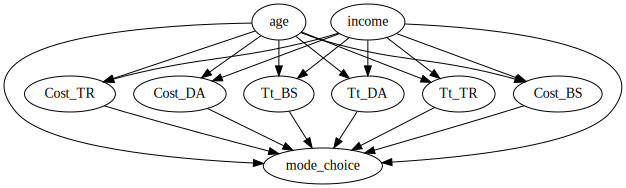

In [39]:
causal_model = StructuralCausalModel({
    "age": lambda     n_samples: data.age,
    "income": lambda  n_samples: data.income,
    "Tt_DA": lambda age,income, n_samples: data.tt_DA,
    "Tt_BS": lambda age,income, n_samples: data.tt_BS,
    "Tt_TR": lambda age,income, n_samples: data.tt_TR,
    "Cost_DA": lambda age,income, n_samples: data.cost_DA,
    "Cost_BS": lambda age,income, n_samples: data.cost_BS,
    "Cost_TR": lambda age,income, n_samples: data.cost_TR,
    "mode_choice": lambda age,income,Tt_DA,Tt_BS,Tt_TR,Cost_DA,Cost_BS,Cost_TR, n_samples: data.choice
})
causal_model.cgm.draw()

# Framework for Simulation from Causal Graph

# 1. Causal Models for each Utility Function 

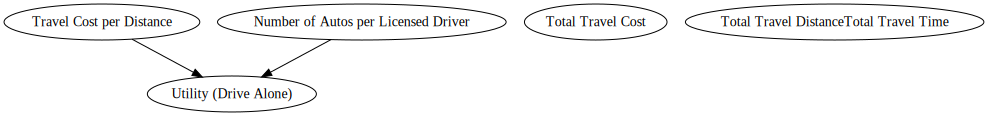

In [15]:
# Define the causal model
V_Drive_Alone = CausalGraphicalModel(nodes=["Total Travel Distance"
                                            "Total Travel Time",
                                            "Total Travel Cost",
                                            "Travel Cost per Distance",
                                            "Number of Autos per Licensed Driver",
                                            "Utility (Drive Alone)"],
                                     edges=[("Total Travel Time", "Travel Cost per Distance"), 
                                         ("Total Travel Time", "Utility (Drive Alone)"), 
                                            ("Number of Autos per Licensed Driver", "Utility (Drive Alone)"), 
                                            ("Travel Cost per Distance", "Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

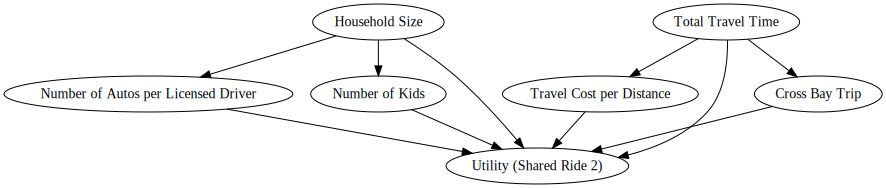

In [16]:
# Define the causal model
V_Shared_2 = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Travel Cost per Distance",
                                         "Cross Bay Trip",
                                         "Number of Autos per Licensed Driver",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 2)"],
                                  edges=[("Total Travel Time","Cross Bay Trip"),
                                         ("Total Travel Time","Travel Cost per Distance"),
                                         ("Total Travel Time", "Utility (Shared Ride 2)"),
                                         ("Number of Autos per Licensed Driver", "Utility (Shared Ride 2)"), 
                                         ("Travel Cost per Distance", "Utility (Shared Ride 2)"),
                                         ("Household Size","Number of Kids"),
                                         ("Household Size","Number of Autos per Licensed Driver"),
                                         ("Household Size", "Utility (Shared Ride 2)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                                         ("Number of Kids", "Utility (Shared Ride 2)")
    ]
)

# draw the causal model
V_Shared_2.draw()

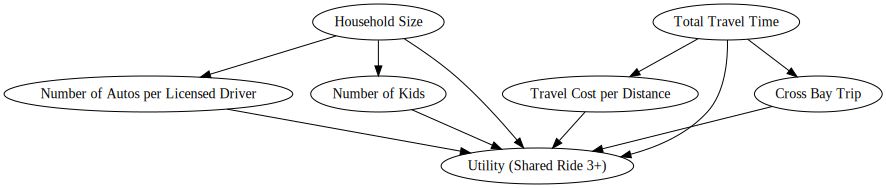

In [17]:
# Define the causal model
V_Shared_3p = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Travel Cost per Distance",
                                         "Cross Bay Trip",
                                         "Number of Autos per Licensed Driver",
                                         "Household Size",
                                         "Number of Kids",
                                         "Utility (Shared Ride 3+)"],
                                  edges=[("Total Travel Time","Cross Bay Trip"),
                                         ("Total Travel Time","Travel Cost per Distance"),
                                         ("Total Travel Time", "Utility (Shared Ride 3+)"),
                                         ("Number of Autos per Licensed Driver", "Utility (Shared Ride 3+)"), 
                                         ("Travel Cost per Distance", "Utility (Shared Ride 3+)"),
                                         ("Household Size","Number of Kids"),
                                         ("Household Size","Number of Autos per Licensed Driver"),
                                         ("Household Size", "Utility (Shared Ride 3+)"),
                                         ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                                         ("Number of Kids", "Utility (Shared Ride 3+)")
    ]
)

# draw the causal model
V_Shared_3p.draw()

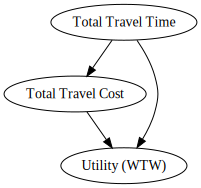

In [18]:
# Define the causal model
V_WTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Cost",
                                         "Utility (WTW)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (WTW)"),
                                         ("Total Travel Cost", "Utility (WTW)")
    ]
)

# draw the causal model
V_WTW.draw()

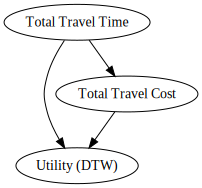

In [19]:
# Define the causal model
V_DTW = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Cost",
                                         "Utility (DTW)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (DTW)"),
                                         ("Total Travel Cost", "Utility (DTW)")
    ]
)

# draw the causal model
V_DTW.draw()

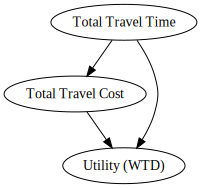

In [20]:
# Define the causal model
V_WTD = CausalGraphicalModel(nodes=["Total Travel Time",
                                         "Total Travel Cost",
                                         "Utility (WTD)"],
                                  edges=[("Total Travel Time", "Total Travel Cost"),
                                         ("Total Travel Time", "Utility (WTD)"),
                                         ("Total Travel Cost", "Utility (WTD)")
    ]
)

# draw the causal model
V_WTD.draw()

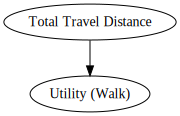

In [21]:
# Define the causal model
V_Walk = CausalGraphicalModel(nodes=["Total Travel Distance",
                                         "Utility (Walk)"],
                                  edges=[("Total Travel Distance", "Utility (Walk)")
    ]
)

# draw the causal model
V_Walk.draw()

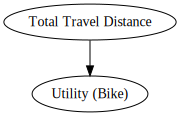

In [22]:
# Define the causal model
V_Bike = CausalGraphicalModel(nodes=["Total Travel Distance",
                                         "Utility (Bike)"],
                                  edges=[("Total Travel Distance", "Utility (Bike)")
    ]
)

# draw the causal model
V_Bike.draw()

## 2. Distribution of Nodes without parents

In [58]:
def DistNodeNoParent(data_long,
                     alt_id_col,
                     obs_id_col,
                     alt_spec_dic,
                     alt_name_dic,
                     ind_spec,
                     trip_spec,
                     var_types,
                     cont_dists=None):

    
    params_dict = {}

    # Code for Individual Specific Variables
    for ind in ind_spec:
        ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])  
        if var_types[ind] in ['categorical', 'numerical']:
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            else:
                params_dict.setdefault(ind,{})['distribution'] = 'categorical'
                np_array_range = np.arange(ind_var.max()+1)
                array_bincount = np.bincount(ind_var)
                probs = array_bincount / len(ind_var)
                params_dict.setdefault(ind,{})['parameters'] = [np_array_range,
                                                  probs]
        else:
            if len(ind_var.unique()) == 1:
                params_dict.setdefault(ind,{})['distribution'] = 'constant'
                params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
            else:
                fitter_object = Fitter(data=ind_var,
                                       distributions=cont_dists,
                                       timeout=30)
                fitter_object.fit()
                BestDict = fitter_object.get_best()
                params_dict.setdefault(ind,{})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(ind,{})['parameters'] = list(BestDict.items())[0][1]

    # Code for Alternative Specific Variables

    for alt in data_long[alt_id_col].unique():
        mode_data = data_long.loc[data_long[alt_id_col] == alt]
        for var in alt_spec_dic[alt]:
            if var_types[var] == 'empirical':
                if len(mode_data[var].unique()) == 1:
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'empirical'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = np.array(mode_data[var])
            elif var_types[var] == 'categorical':
                if len(mode_data[var].unique()) == 1:
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'categorical'
                    np_array_range = np.arange(mode_data[var].max()+1)
                    array_bincount = np.bincount(mode_data[var])
                    probs = array_bincount / len(mode_data[var])
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = [np_array_range,
                                                                            probs]
            else:
                if len(mode_data[var].unique()) == 1:
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
                else:
                    fitter_object = Fitter(data=mode_data[var],
                                           distributions=cont_dists,
                                           timeout=30)
                    fitter_object.fit()
                    BestDict = fitter_object.get_best()
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = list(BestDict.items())[0][0]
                    params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = list(BestDict.items())[0][1]

    # Trip Specific Variable (maybe combine with individual specific variables)
    for var in trip_spec:
        trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
        if var_types[var] == 'empirical':
            if trip_var.unique() == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var.unique())
            else:
                params_dict.setdefault(var, {})['distribution'] = 'empirical'
                params_dict.setdefault(var, {})['parameters'] = np.array(trip_var)
        elif var_types[var] == 'categorical':
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            else:
                params_dict.setdefault(var, {})['distribution'] = 'categorical'
                np_array_range = np.arange(trip_var.max()+1)
                array_bincount = np.bincount(trip_var)
                probs = array_bincount / len(trip_var)
                params_dict.setdefault(var, {})['parameters'] = [np_array_range,
                                                  probs]
        else:
            if len(trip_var.unique()) == 1:
                params_dict.setdefault(var, {})['distribution'] = 'constant'
                params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
            else:
                fitter_object = Fitter(data=trip_var,
                                       distributions=cont_dists,
                                       timeout=30)
                fitter_object.fit()
                BestDict = fitter_object.get_best()
                params_dict.setdefault(var, {})['distribution'] = list(BestDict.items())[0][0]
                params_dict.setdefault(var, {})['parameters'] = list(BestDict.items())[0][1]

    return params_dict

In [50]:
observation_id_col = 'observation_id'

alternative_id_col = 'mode_id'

variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical'}

individual_specific_variables = ['household_size']

alternative_specific_dict = {1:['total_travel_time'],
                             2:['total_travel_time'],
                             3:['total_travel_time'],
                             4:['total_travel_time'],
                             5:['total_travel_time'],
                             6:['total_travel_time'],
                             7:['total_travel_distance'],
                             8:['total_travel_distance']}

trip_specific_variables = ['cross_bay']

alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'categorical',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time': 'continuous',
                 'total_travel_distance': 'continuous',
                 'total_travel_cost': 'continuous'}

distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

In [59]:
bike_data_params = DistNodeNoParent(data_long=bike_data_long,
                                    alt_id_col=alternative_id_col,
                                    obs_id_col=observation_id_col,
                                    alt_spec_dic=alternative_specific_dict,
                                    alt_name_dic=alternative_name_dict,
                                    ind_spec=individual_specific_variables,
                                    trip_spec=trip_specific_variables,
                                    var_types=variable_type,
                                    cont_dists=distributions)

SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.0007989652291582563)
Fitted beta distribution with error=0.00021837510493444555)
Fitted gamma distribution with error=0.00021215664843294874)
Fitted expon distribution with error=0.00042675380208476757)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.001056930694286857)
Fitted beta distribution with error=0.0002880878794523213)
Fitted gamma distribution with error=0.00028798219056962133)
Fitted expon distribution with error=0.0006139993763181574)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.0010612734128178794)
Fitted beta distribution with error=0.00023601477811189558)
Fitted gamma distribution with error=0.00023611716873763347)
Fitted expon distribution with error=0.000607621

In [60]:
bike_data_params

{'household_size': {'distribution': 'categorical',
  'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
   array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
          0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
 'total_travel_time_drive_alone': {'distribution': 'gamma',
  'parameters': (1.1904155586172542, 3.907812363125747, 21.638960450841715)},
 'total_travel_time_shared_2': {'distribution': 'gamma',
  'parameters': (1.2282663917500747, 3.907290321681425, 20.498677252491284)},
 'total_travel_time_shared_3p': {'distribution': 'beta',
  'parameters': (1.2555415924211217,
   242955595327.49966,
   3.9067655511727146,
   4780671990083.65)},
 'total_travel_time_wtw': {'distribution': 'alpha',
  'parameters': (3.9577465114167927, -98.3112671568787, 749.7787691208105)},
 'total_travel_time_dtw': {'distribution': 'gamma',
  'parameters': (2.6059274863539046, 8.099701135792749, 30.976197249989433)},
 'total_travel_time_wtd': {'distribution': 'gamma',
  'param

## 3. Regression Parameters function

In [143]:
def FitAlternativeRegression(regressions, reg_types, data):
    
    regression_results = {}
    
    for reg in regressions.keys():
        if reg_types[reg] == 'linear':
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]

            model = sm.OLS(data_y, data_x)

            results = model.fit()
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
        
        if reg_types[reg] == 'logistic':
            data_x = sm.add_constant(data[regressions[reg][0]])
            data_y = data[regressions[reg][1]]

            model = sm.Logit(data_y, data_x)

            results = model.fit()
            regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
    
    #if plotting:
    #    fig = plt.figure(figsize=(12,8))
    #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return regression_results

# 4. Simulate Nodes without Parents 

In [61]:
def SimNodeNoParent(params_dict, size=1000):
        """Funtion to simulate data of size N based on specified
        distribution/parameters found by the fitter package.
        Inputs:
        -------
        data: dataframe from which columns are to be taken
        dist_params: the distribution parameters from find_dist_df
        Outputs:
        -------
        DataFrame object with simulated data based on specified distributions
        """
        Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
        Sim_Df = Sim_Df.fillna(0)
        for column in list(params_dict.keys()):
            if params_dict[column]['distribution'] == 'categorical':
                value = params_dict[column]['parameters'][0]
                freq = params_dict[column]['parameters'][1]
                data_sim = np.random.choice(a=value,
                                            p=freq,
                                            size=size)
                Sim_Df[column] = data_sim
            elif params_dict[column]['distribution'] == 'constant':
                data_sim = params_dict[column]['parameters'][0]
                Sim_Df[column] = data_sim
            elif params_dict[column]['distribution'] == 'empirical':
                data_sim = np.random.choice(params_dict[column]['paramaters'], size=size)
                Sim_Df[column] = data_sim
            else:
                dist = getattr(scipy.stats,
                               params_dict[column]['distribution'])
                data_sim = dist.rvs(*params_dict[column]['parameters'],
                                    size=size)
                Sim_Df[column] = data_sim
        return Sim_Df

In [62]:
SimNodeNoParent(bike_data_params)

,household_size,total_travel_time_drive_alone,total_travel_time_shared_2,total_travel_time_shared_3p,total_travel_time_wtw,total_travel_time_dtw,total_travel_time_wtd,total_travel_distance_walk,total_travel_distance_bike,cross_bay
0,4.0,35.698805,19.491829,12.330947,180.765942,36.537338,71.285630,15.745893,1.783789,0
1,1.0,18.938443,53.776755,10.241975,74.458282,60.125617,27.632404,1.068084,9.414602,0
2,4.0,20.665022,38.297161,75.570846,116.879360,110.331999,41.086839,6.673066,9.002365,0
3,7.0,29.675873,13.363029,6.064114,50.499976,28.972667,55.034022,1.774374,4.558961,0
4,4.0,28.801045,31.146192,35.432011,169.429542,46.121339,34.859274,7.956355,23.799623,0
...,...,...,...,...,...,...,...,...,...,...
995,5.0,45.576607,12.037434,8.923053,83.095909,93.906886,138.038983,1.146684,20.551282,0
996,2.0,47.874094,35.843382,9.563665,40.858440,53.064384,163.403581,4.378566,7.616057,0
997,5.0,15.924144,27.815758,6.865069,122.553222,123.944192,187.815085,35.319919,0.455679,1
998,3.0,33.732885,13.886981,77.360396,176.726996,74.927851,64.326112,18.804987,149.577104,0
